# Verification of the train dataset

Imports and data loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_jsonl_df(jsonl_file, lab=False):
    user_contents = []
    assistant_contents = []
    labels = []

    with open(jsonl_file, 'r') as file:
        for line in file:
            data = json.loads(line)
            message = data['messages']
            user_contents.append(message[0]['content'])
            assistant_contents.append(message[1]['content'])
            if lab == True:
                labels.append(data['target'])


    if lab == True:
        df = pd.DataFrame({
            'user_content': user_contents,
            'assistant_content': assistant_contents,
            'target' : labels
            })
    else:
        df = pd.DataFrame({
            'user_content': user_contents,
            'assistant_content': assistant_contents
            })
    return df

In [3]:
data_lab = load_jsonl_df('dataset/train_dataset_lab.jsonl', lab=True)
data_lab.shape

(1000, 3)

In [4]:
data_lab.head()

,user_content,assistant_content,target
0,"List of genes : <<< B3GAT2,FUT4,POMGNT2 >>>\nL...",The experiment identified the Mannose type O-g...,Mannose type O-glycan biosynthesis
1,"List of genes : <<< ACOX3,PLA2G12A,PLAAT2,PLA2...",The metabolic pathway identified in this exper...,alpha-Linolenic acid metabolism
2,"List of genes : <<< HADHB,ELOVL1,THEM5,ELOVL3,...",Based on the provided list of genes and compou...,Fatty acid elongation
3,"List of genes : <<< EHHADH,OXCT1 >>>\nList of ...",The metabolic pathway identified in the experi...,Butanoate metabolism
4,"List of genes : <<< IDH1,PKM,SHMT1,SDS >>>\nLi...",The metabolic pathway identified in the experi...,Biosynthesis of amino acids


## Pathway in assistant response is the right one

In [5]:
def verify_response(row):
    if row.iloc[2].lower() in row.iloc[1].lower():
        return True
    else:
        return False

In [6]:
data_lab['Correct'] = data_lab.apply(verify_response, axis=1)

In [7]:
data_lab["Correct"].value_counts()

Correct
True     952
False     48
Name: count, dtype: int64

In [8]:
def print_cells(row):
    print(row.iloc[2])
    print(row.iloc[1] + '\n\n')

In [ ]:
data_lab.loc[data_lab["Correct"] == False].apply(print_cells, axis=1)

After checking the 48 incorrect lines, it seems that differences occured because of addition/suppression of special characters in pathway names.
Because of that, the exact pathway name was not detected, but answers were correct.

In [11]:
data_lab = data_lab.drop("Correct", axis=1)
data_lab.shape

(1000, 3)

## Representation of each pathway

Iter1 : The representation of some pathways seems a little imbalanced, especially for pathway that are quite specific but represented a lot. Some pathways still have only one representation, highlighting the need for further generation. New generation was performed excluding these highly represented pathways.

Iter2 : The representation is still quite imbalanced. Running new generation with only the pathways with less than 4 examples, excluding pathway which to my knowledge are not very specific or quite rare.

Iter3 : After first fine-tuning attempt, I thought that I do not have enough data, so decided to generate more by implementing a method to make the model generate at least 11 examples per pathway. For that I need the list of pathway codes and the count of examples (dict {pathwaycode : exemple_count}, stored in a pathway_vc.csv file.

Examples generation, as well as management of the pathway_vc.csv file, is performed in the [examplegeneration.py](../examplegeneration.py) script.

In [12]:
keggdf = pd.read_json('prompts/pathway_genes_compounds.json', orient='index')
keggdf.head()

,name,genes,compounds
hsa01200,Carbon metabolism,"[ME3, SDS, SDSL, , ADH5, GLYCTK, CPS1, GOT1L1,...","[D-Fructose 6-phosphate, D-Ribulose 1,5-bispho..."
hsa01210,2-Oxocarboxylic acid metabolism,"[ABHD14A-ACY1, GOT1L1, CS, NAGS, DBT, DLAT, DL...","[8-Methylthiooctyl glucosinolate, 2-Oxo-10-met..."
hsa01212,Fatty acid metabolism,"[ACAA2, HTD2, CPT1C, CPT1A, CPT1B, CPT2, ECHS1...","[Acetyl-CoA, Acetyl-[acyl-carrier protein], Ac..."
hsa01230,Biosynthesis of amino acids,"[ABHD14A-ACY1, , SDS, SDSL, CPS1, GOT1L1, CS, ...","[N6-Acetyl-LL-2,6-diaminoheptanedioate, (Z)-Bu..."
hsa01232,Nucleotide metabolism,"[ADA, NT5C1B-RDH14, NME6, AK6, NT5C3B, AK7, AD...","[IMP, IDP, ITP, AMP, ADP, ATP, Inosine, Adenos..."


In [13]:
pd.set_option('display.max_rows', 99)
vc = data_lab['target'].value_counts().to_dict()

<BarContainer object of 88 artists>

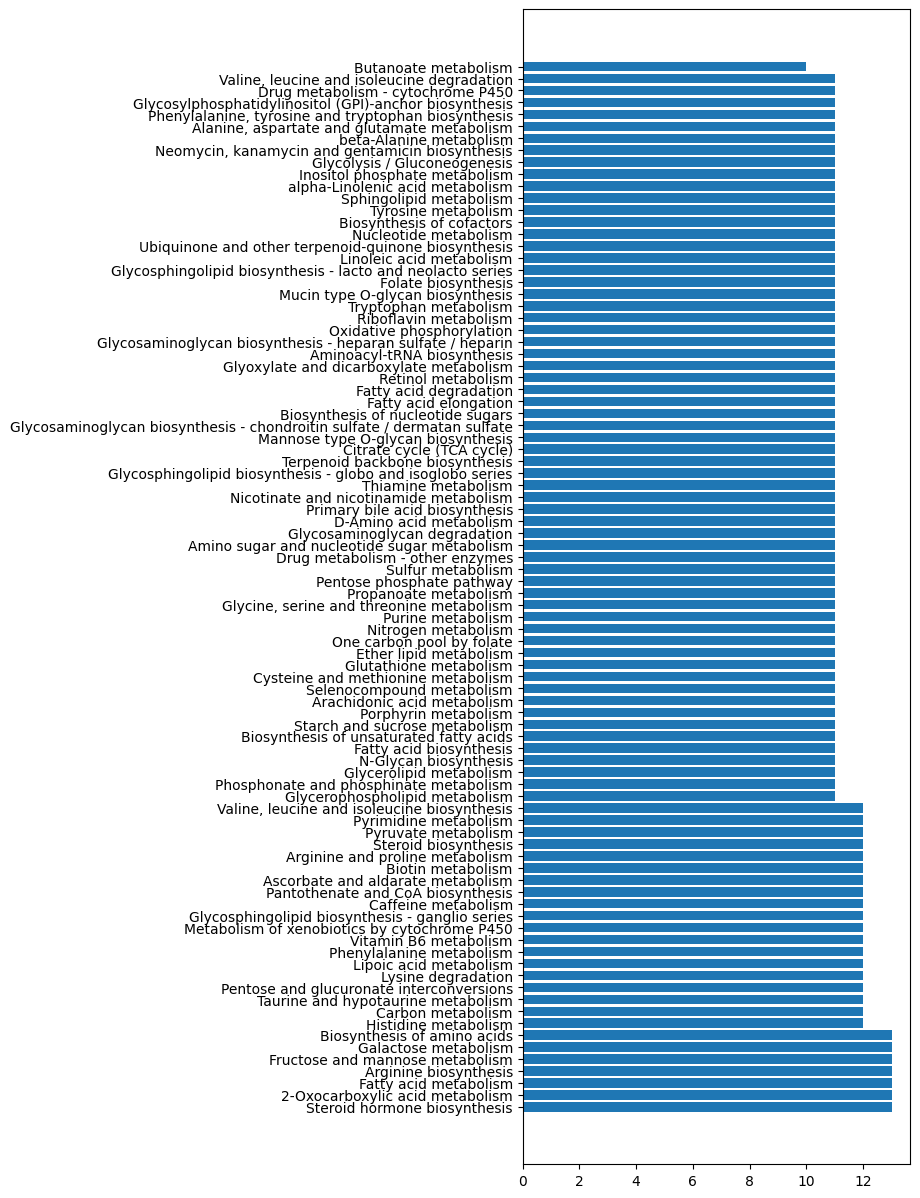

In [16]:
fig, ax1 = plt.subplots(figsize=(5,15))
ax1.barh(vc.keys(), vc.values())